## `ramp_fitting` step

This step determines the mean count rate for each pixel by performing a linear fit to the pixel ramps. The count rate is determined by a linear fit to the cosmic-ray-free and saturation-free ramp segments for each pixel. Segments are derived using the 4-D GROUPDQ array of the input data set, under the assumption that the jump step will have already flagged CR’s. Segments are also terminated where saturation flags are found. 

Official documentation for `ramp_fitting` can be found here:

<https://jwst-pipeline.readthedocs.io/en/latest/jwst/ramp_fitting/index.html>

Note that there are special use cases for this step (e.g. single group integrations) so the official documentation should be consulted for these cases.

### Input data

An example of running the `ramp_fitting` step is now shown using a simple simulated observation of a galaxy with the MIRI Imager (F1130W filter) produced with [MIRISim v2.3](https://wiki.miricle.org/Public/MIRISim_Public), with precending pipeline steps applied, i.e. `jump` output.

### Python

Start by importing what will be used and set the `CRDS_CONTEXT`

In [1]:
# imports
import os, glob, shutil
import numpy as np
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from jwst import datamodels

# set the CRDS_CONTEXT
os.environ["CRDS_CONTEXT"] = "jwst_0641.pmap"

Import `jump` and print the docstring and spec to show some information

In [2]:
# import the step
from jwst.ramp_fitting import ramp_fit_step

# print the description and options
print(ramp_fit_step.RampFitStep.__doc__)
print(ramp_fit_step.RampFitStep.spec)



    This step fits a straight line to the value of counts vs. time to
    determine the mean count rate for each pixel.
    

        int_name = string(default='')
        save_opt = boolean(default=False) # Save optional output
        opt_name = string(default='')
        maximum_cores = option('none', 'quarter', 'half', 'all', default='none') # max number of processes to create
    


Set the name of the input file and run the step. This will produce an output file ending with `_rampfitstep.fits`

*Parameters used:*

`output_use_model` : boolean, optional, default=False  
&nbsp;&nbsp;&nbsp;&nbsp; propagate the input filename to the output
    
`save_results`: boolean, optional, default=False  
&nbsp;&nbsp;&nbsp;&nbsp; save the results to file

Note that the `ramp_fitting` will return the output datamodel(s) depending on the input. If the input file has only one integration, `ramp_fitting` will return the rate image datamodel. If the number of integrations is greater than 1, it will also return the rate-per-intgration datamodel, which can be used for TSO analysis. 

*Parameters unused:*

`save_opt` : boolean, optional, default=False  
&nbsp;&nbsp;&nbsp;&nbsp; save the fit parameters. If the user is interested in the ramp segment fit parameters (slopes, intercepts, etc.) then this file should be saved. An example of &nbsp;&nbsp;&nbsp;&nbsp; using this file is given below.

In [3]:
# user specified
my_input_file = 'det_image_seq1_MIRIMAGE_F1130Wexp1_jumpstep.fits'

# run the step
dm, dm_tso = ramp_fit_step.RampFitStep.call(my_input_file, output_use_model=True, save_results=True)


2020-10-29 14:29:19,047 - CRDS - ERROR -  Error determining best reference for 'pars-rampfitstep'  =   Unknown reference type 'pars-rampfitstep'
2020-10-29 14:29:19,050 - stpipe.RampFitStep - INFO - RampFitStep instance created.
2020-10-29 14:29:19,144 - stpipe.RampFitStep - INFO - Step RampFitStep running with args ('det_image_seq1_MIRIMAGE_F1130Wexp1_jumpstep.fits',).
2020-10-29 14:29:19,146 - stpipe.RampFitStep - INFO - Step RampFitStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}
2020-10-29 14:29:19,431 - stpipe.RampFitStep - INFO - Using READNOISE reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0059.fits
2020-10-29 14:29:19,495 - stpipe.RampFitSt

We can now plot the input ramp image and the output slope (rate) image

2020-10-29 14:30:47,390 - stpipe - WARNING - /Users/patrickkavanagh/anaconda3/anaconda3/envs/jwst7.6/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



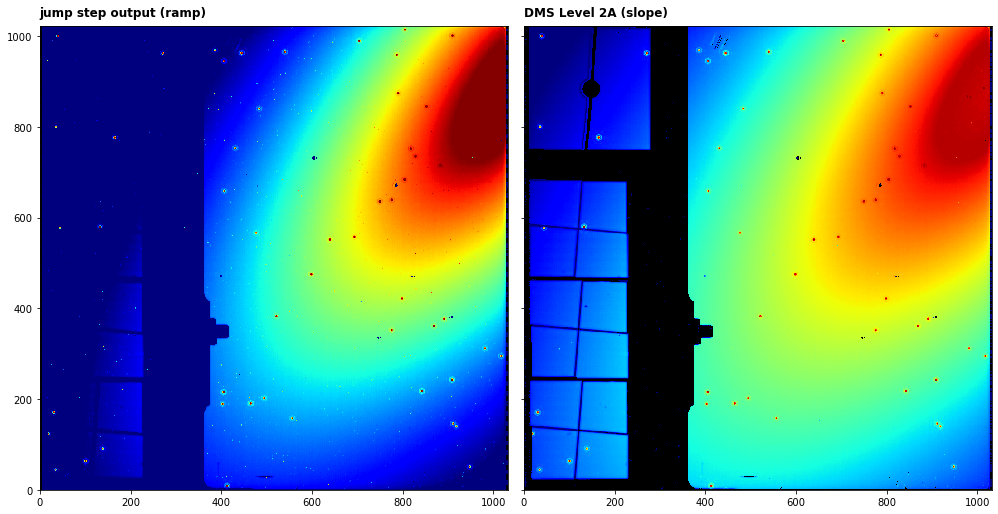

In [8]:
# open input file
in_dm = datamodels.open('det_image_seq1_MIRIMAGE_F1130Wexp1_jumpstep.fits')

# plot
fig, axs = plt.subplots(1, 2, figsize=(14, 7), sharey=True)

axs[0].imshow(in_dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=1.1e4,vmax=6.5e4))
axs[0].annotate('jump step output (ramp)', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[0].set_facecolor('black')
axs[1].imshow(dm.data, cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=10, vmax=150))
axs[1].annotate('DMS Level 2A (slope)', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[1].set_facecolor('black')
plt.tight_layout()
plt.show()

### Command line

To achieve the same result from the command line there are a couple of options. 

**Option 1:**
Run the `RampFitStep` class using the `strun` command:

```bash
strun jwst.ramp_fitting.RampFitStep det_image_seq1_MIRIMAGE_F1130Wexp1_jumpstep.fits
```

**Option 2:**
If they don't already exist, collect the pipeline configuration files in your working directory using `collect_pipeline_configs` and then run the `RampFitStep` using the `strun` command with the associated `ramp_fit.cfg` file. 

```bash
collect_pipeline_cfgs cfgs/

strun cfgs/ramp_fit.cfg det_image_seq1_MIRIMAGE_F1130Wexp1_jumpstep.fits
```

This will produce the same output file ending with `_rampfitstep.fits` 


A full list of the command line options are given by running the following:

```bash
strun jwst.ramp_fitting.RampFitStep -h
```

or 

```bash
strun cfgs/ramp_fit.cfg -h
```


### Override reference file

The `ramp_fitting` step uses the readnoise and gain reference files. During ramp fitting, the GAIN values are used to temporarily convert the pixel values from units of DN to electrons, and convert the results of ramp fitting back to DN. The READNOISE values are used as part of the noise estimate for each pixel. Both are necessary for proper computation of noise estimates. To override these in Python:

```python
# set the readnoise and gain reference file names
my_ref_rn = 'my_readnoise.fits'
my_ref_gn = 'my_gain.fits'

dm, dm_tso = ramp_fit_step.RampFitStep.call(my_input_file, output_use_model=True, save_results=True,
                                            override_readnoise=my_ref_rn, override_gain=my_ref_gn)
```

and using the command line:

```bash
strun jwst.ramp_fitting.RampFitStep det_image_seq1_MIRIMAGE_F1130Wexp1_jumpstep.fits  --override_readnoise my_readnoise.fits --override_gain my_gain.fits
```

or

```bash
strun cfgs/ramp_fit.cfg det_image_seq1_MIRIMAGE_F1130Wexp1_jumpstep.fits  --override_readnoise my_readnoise.fits --override_gain my_gain.fits
```

### Save the segment fit results using `save_opt`

As stated above, the fit results to ramp segments can be saved using the `save_opt` parameter. The file will be saved with name ending `_fitopt.fits`. To do this in Python:

In [9]:
dm, dm_tso = ramp_fit_step.RampFitStep.call(my_input_file, output_use_model=True, save_results=True,
                                            save_opt=True)


2020-10-29 14:31:08,315 - stpipe - WARNING - /Users/patrickkavanagh/anaconda3/anaconda3/envs/jwst7.6/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)

2020-10-29 14:31:08,778 - CRDS - ERROR -  Error determining best reference for 'pars-rampfitstep'  =   Unknown reference type 'pars-rampfitstep'
2020-10-29 14:31:08,780 - stpipe.RampFitStep - INFO - RampFitStep instance created.
2020-10-29 14:31:08,858 - stpipe.RampFitStep - INFO - Step RampFitStep running with args ('det_image_seq1_MIRIMAGE_F1130Wexp1_jumpstep.fits',).
2020-10-29 14:31:08,859 - stpipe.RampFitStep - INFO - Step RampFitStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fi

and using the command line:

```bash
strun jwst.ramp_fitting.RampFitStep det_image_seq1_MIRIMAGE_F1130Wexp1_jumpstep.fits --save_opt
```

or

```bash
strun cfgs/ramp_fit.cfg det_image_seq1_MIRIMAGE_F1130Wexp1_jumpstep.fits --save_opt
```

We can plot the fits to individual segments in the integrations. In the sample file there are two integrations. The segment fits are shown with the segment slopes, weights and final slope value.

2020-10-29 14:33:15,053 - stpipe - WARNING - /Users/patrickkavanagh/anaconda3/anaconda3/envs/jwst7.6/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



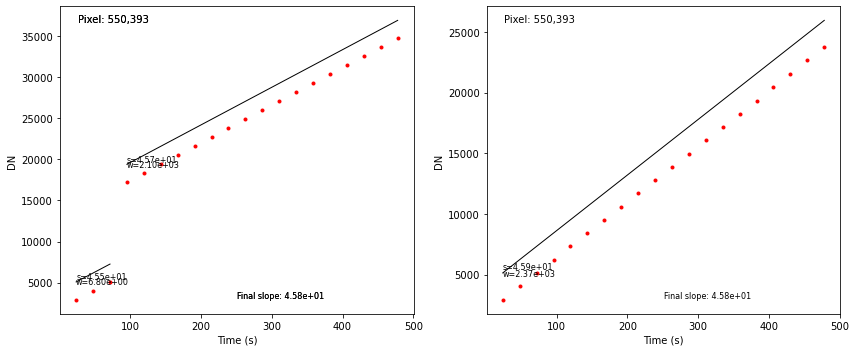

In [11]:
# load the fit results file and input file to a datamodel
fitopt_dm = datamodels.RampFitOutputModel('det_image_seq1_MIRIMAGE_F1130Wexp1_fitopt.fits')
in_dm = datamodels.open(my_input_file)

# set the sample pixel (selected knowing there is a jump on the ramp)
pixel = [550, 393]

# get the output slope value
final_slope = dm.data[pixel[1], pixel[0]]

# plot
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# in this case there are two integrations, show each
for int_num in [0, 1]:
    
    # identify the jump indices using the jump flag in the groupdq extension
    groupdq_ramp = in_dm.groupdq[int_num, :, pixel[1], pixel[0]]
    idx = [i for i ,v in enumerate(groupdq_ramp >= 4) if v]

    # get the number of segments
    seg_num = len(idx) + 1

    # add extra element to the start of the idx array to make plotting easier
    idx = [0] + idx

    if len(idx) > 1:
        # cycle through segments
        for n in range(seg_num):
            
            try:
                ramp_seg = in_dm.data[int_num, idx[n]:idx[n+1], pixel[1], pixel[0]]
                group = np.arange(idx[n], idx[n+1])
            except IndexError:
                ramp_seg = in_dm.data[int_num, idx[n]:, pixel[1], pixel[0]]
                group = np.arange(idx[n], in_dm.data.shape[1])
                

            # convert group number to exposure time
            exp_time = (group+1) * in_dm.meta.exposure.group_time

            # plot the ramp segments
            axs[int_num].plot(exp_time, ramp_seg, marker='o', markersize=3, linestyle='-', linewidth=0, c='r')

            # get the slopes/intercepts for the segment from the datamodel
            slope = fitopt_dm.slope[int_num, n, pixel[1], pixel[0]]
            yint = fitopt_dm.yint[int_num, n, pixel[1], pixel[0]]
            weight = fitopt_dm.weights[int_num, n, pixel[1], pixel[0]]
            
            # plot fit to the segment
            fit = slope * exp_time + yint
            axs[int_num].plot(exp_time, fit, marker='o', markersize=0, linestyle='-', linewidth=1, c='k')
            axs[int_num].annotate('s=%0.2e' % slope, xy=(min(exp_time), min(fit)+300), fontsize=8, color='k')
            axs[int_num].annotate('w=%0.2e' % weight, xy=(min(exp_time), min(fit)-300), fontsize=8, color='k')

            axs[int_num].annotate('Final slope: %0.2e' % final_slope, xy=(0.5, 0.05), 
                                 xycoords='axes fraction', fontsize=8, color='k')
            axs[int_num].annotate('Pixel: %d,%d' % (pixel[0],pixel[1]), xy=(0.05, 0.95), 
                                 xycoords='axes fraction', fontsize=10, color='k')
            axs[int_num].set_xlabel('Time (s)')
            axs[int_num].set_ylabel('DN')
            
    else:
        ramp_seg = in_dm.data[int_num, :, pixel[1], pixel[0]]
        group = np.arange(in_dm.data.shape[1]) + 1

        # convert group number to exposure time
        exp_time = group * in_dm.meta.exposure.group_time

        # plot the ramp segments
        axs[int_num].plot(exp_time, ramp_seg, marker='o', markersize=3, linestyle='-', linewidth=0, c='r')

        # get the slopes/intercepts for the segment from the datamodel
        slope = fitopt_dm.slope[int_num, 0, pixel[1], pixel[0]]
        yint = fitopt_dm.yint[int_num, 0, pixel[1], pixel[0]]
        weight = fitopt_dm.weights[int_num, 0, pixel[1], pixel[0]]

        # plot fit to the segment
        fit = slope * exp_time + yint
        axs[int_num].plot(exp_time, fit, marker='o', markersize=0, linestyle='-', linewidth=1, c='k')
        axs[int_num].annotate('s=%0.2e' % slope, xy=(min(exp_time), min(fit)+300), fontsize=8, color='k')
        axs[int_num].annotate('w=%0.2e' % weight, xy=(min(exp_time), min(fit)-300), fontsize=8, color='k')

        axs[int_num].annotate('Final slope: %0.2e' % final_slope, xy=(0.5, 0.05), 
                             xycoords='axes fraction', fontsize=8, color='k')
        axs[int_num].annotate('Pixel: %d,%d' % (pixel[0],pixel[1]), xy=(0.05, 0.95), 
                             xycoords='axes fraction', fontsize=10, color='k')
        axs[int_num].set_xlabel('Time (s)')
        axs[int_num].set_ylabel('DN')

plt.tight_layout()
plt.show()
